## Null hypothesis: age distribution of citibike riders is normally distributed
## Alternative hypothesis: age distribution of citibke riders is not normally distributed
## Alpha = 0.05

#### Conclusions in this notebook are based on citibike data for the month of February 2014. Our findings seem to be the same or similar to others who have used other months and/or larger datasets.

In [100]:
# imports and setup
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import zipfile as zp
import scipy.stats as stats

%pylab inline

import os

Populating the interactive namespace from numpy and matplotlib


In [3]:
"""
Function to download and unzip data from Federica Bianco
"""

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
                os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [4]:
datestring = '201402'
getCitiBikeCSV(datestring)

file in place, you can continue


In [5]:
data = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')

In [6]:
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,382,2014-02-01 00:00:00,2014-02-01 00:06:22,294,Washington Square E,40.730494,-73.995721,265,Stanton St & Chrystie St,40.722293,-73.991475,21101,Subscriber,1991,1
1,372,2014-02-01 00:00:03,2014-02-01 00:06:15,285,Broadway & E 14 St,40.734546,-73.990741,439,E 4 St & 2 Ave,40.726281,-73.989780,15456,Subscriber,1979,2
2,591,2014-02-01 00:00:09,2014-02-01 00:10:00,247,Perry St & Bleecker St,40.735354,-74.004831,251,Mott St & Prince St,40.723180,-73.994800,16281,Subscriber,1948,2
3,583,2014-02-01 00:00:32,2014-02-01 00:10:15,357,E 11 St & Broadway,40.732618,-73.991580,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,17400,Subscriber,1981,1
4,223,2014-02-01 00:00:41,2014-02-01 00:04:24,401,Allen St & Rivington St,40.720196,-73.989978,439,E 4 St & 2 Ave,40.726281,-73.989780,19341,Subscriber,1990,1


In [7]:
data.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [8]:
# dropping unwanted columns
data_age_dist = data.drop(['tripduration', 'starttime', 'stoptime', 'start station id', 'start station name', 'start station latitude', 
          'start station longitude', 'end station id', 'end station name', 'end station latitude', 'end station longitude',
          'bikeid'], axis = 1)

In [36]:
# casting 'birth year' from str to int so we can calculate age
data_age_dist[['birth year']] = data_age_dist[['birth year']].astype(int)

In [39]:
# dropping customers where we don't know the gender or birthyear, adding age column
data_age_dist = data_age_dist[data_age_dist['gender'] != 0]
data_age_dist.reset_index(drop=True)
data_age_dist['age'] = 2014 - data_age_dist['birth year']
data_age_dist.head()

,usertype,birth year,gender,age
0,Subscriber,1991,1,23
1,Subscriber,1979,2,35
2,Subscriber,1948,2,66
3,Subscriber,1981,1,33
4,Subscriber,1990,1,24


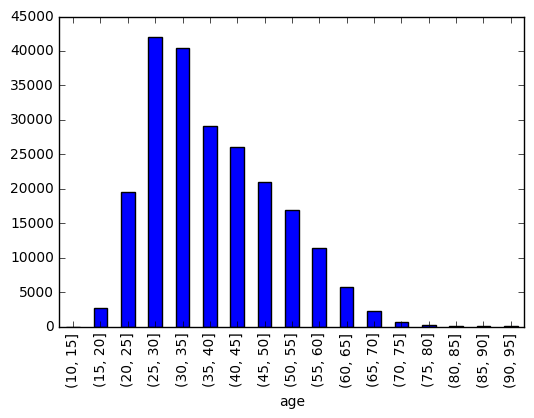

In [116]:
# plotting age distribution, code from Federica Bianco
bins = np.arange(10, 99, 5)
ax = data_age_dist.age.groupby(pd.cut(data_age_dist.age, bins)).agg([count_nonzero]).plot(kind='bar', 
                                                                legend=False)

## Kolmogorov–Smirnov test

In [123]:
# running our age dist against a normal dist with the same parameters
scipy.stats.kstest(data_age_dist['age'], stats.norm.cdf, args=(np.mean(data_age_dist['age']), np.std(data_age_dist['age'])))

KstestResult(statistic=0.099994033007425653, pvalue=0.0)

In [201]:
# running the same test with the standard normal dist after having standardized my dataset, should yield same results
from sklearn import preprocessing
Age_scaled = preprocessing.scale(data_age_dist['age'])
scipy.stats.kstest(Age_scaled, stats.norm.cdf)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


KstestResult(statistic=0.099994033007425653, pvalue=0.0)

In [179]:
n = 1.358/(np.sqrt(size(data_age_dist['age'])))
n

0.0029084830874298324

#### With a p-value of 0.0 we can reject the null hypothesis and state that the agedistribution of citibike riders is not normally contributed. The KS test statistic is larger than our table value (0.0029), hence the p-value is very small.

In [198]:
scipy.stats.kstest(data_age_dist['age'], stats.chi2.cdf, args=(np.mean(data_age_dist['age']), np.std(data_age_dist['age'])))

KstestResult(statistic=0.4919170232195475, pvalue=0.0)

In [200]:
scipy.stats.kstest(data_age_dist['age'], stats.poisson.cdf, args=(np.mean(data_age_dist['age']), np.std(data_age_dist['age'])))

KstestResult(statistic=0.56737021787235686, pvalue=0.0)

#### Here we are testing weather the citibike riders agedistribution is compatible with chi-square dist on the one hand and poisson on the other. For both of these we get a p-value of 0.0 and therefor conclude that they are not chi-square nor poisson distributed.

## Anderson-Darling test

In [208]:
scipy.stats.anderson(data_age_dist['age'], 'norm')

AndersonResult(statistic=2793.4941205939976, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [193]:
scipy.stats.anderson(data_age_dist['age'], 'logistic')

AndersonResult(statistic=2674.4827113587235, critical_values=array([ 0.426,  0.563,  0.66 ,  0.769,  0.906,  1.01 ]), significance_level=array([ 25. ,  10. ,   5. ,   2.5,   1. ,   0.5]))

#### The Anderson-Darling statistic is greater than the values in the critical array. We can therefor reject the null hypothesis that age of citibike riders is normally distributed (or logistically distributed in the second case) for all significance levels stated in the second array.